In [1]:
from urllib.request import Request, urlopen

import json

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import datasets

In [2]:
# virus tracker data (broken)
# m = pd.read_csv('data/virus_tracker_mapping.txt', sep='\t',
#                 names=['country', 'countrycode', '_'], usecols=['country', 'countrycode'])
# m['country'] = m['country'].str[3:]
# m['countrycode'] = m['countrycode'].str[:2]
# m.rename(columns=str.title, inplace=True)
# m.set_index('Countrycode', inplace=True)

# df = pd.DataFrame(data['data'])
# countrycodes = set(df['countrycode'])
# df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
# df.rename(columns=str.title)
# df.sort_values(['countrycode', 'date'], inplace=True)
# df.rename(columns=str.title, inplace=True)
# df.set_index(['Countrycode', 'Date'] , inplace=True)
# df = df.applymap(int)

In [3]:
d = {
    'Cases': 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
    'Deaths': 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
    'Recovered': 'https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
}
data = {}

In [4]:
for key, value in d.items():
    headers = {'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36'}
    req = Request(value, headers=headers)
    with urlopen(req) as res:
        df = pd.read_html(res.read())[0].drop(columns=['Unnamed: 0', 'Lat', 'Long']).groupby("Country/Region").sum()
    df.rename(columns=pd.to_datetime, inplace=True)
    ser = df.unstack()
    ser.index.names = ['Date', 'Country']
    ser.name = key
    data[key] = ser

In [5]:
countries = set(df.index)

In [6]:
df = pd.DataFrame(data).swaplevel()
df.sort_values(['Country', 'Date'], inplace=True)
df.head()

Cases  Deaths  Recovered
Country     Date                                
Afghanistan 2020-01-22      0       0          0
            2020-01-23      0       0          0
            2020-01-24      0       0          0
            2020-01-25      0       0          0
            2020-01-26      0       0          0

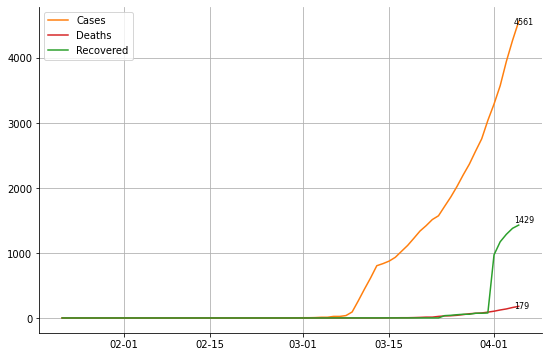

In [7]:
colors = ['tab:orange', 'tab:red', 'tab:green']

def draw_timeline(data, country):
    fig, ax = plt.subplots(figsize=(9, 6))
    c, d, r = data.last('1D').iloc[0]
    for (label, content), color, i in zip(data.iteritems(), colors, [0, 0, 5 if (d-r)/(r+1e-10) <= 0.15 else -5]):
        ax.plot(content, label=label, color=color)
        ax.annotate(content[-1], xy=(ax.get_xticks()[-1], content[-1]),
                    xycoords=ax.transData, xytext=(20, i), textcoords='offset points',
                    va='center', ha='left', fontsize=8)
    ax.set_title(f'{country}')
    ax.get_xaxis().set_major_formatter(mpl.dates.DateFormatter('%m-%d'))
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend()
    plt.savefig(f'./country_timeline/{country}.png')
draw_timeline(df.loc['Denmark'], '')

In [170]:
for country in countries:
    draw_timeline(df.loc[country], country)
    plt.close()

In [13]:
import os
l = [file for file in sorted(os.listdir('country_timeline')) if file.endswith('png')][1:]

In [28]:
_ = 'A'
print(f'### {}')
for file in l:
    if file[0] > _:
        _ = file[0]
        print(f'### {_}')
    print(f'![]({file})')

A
![](Afghanistan.png)
![](Albania.png)
![](Algeria.png)
![](Andorra.png)
![](Angola.png)
![](Antigua and Barbuda.png)
![](Argentina.png)
![](Armenia.png)
![](Australia.png)
![](Austria.png)
![](Azerbaijan.png)
### B
![](Bahamas.png)
![](Bahrain.png)
![](Bangladesh.png)
![](Barbados.png)
![](Belarus.png)
![](Belgium.png)
![](Belize.png)
![](Benin.png)
![](Bhutan.png)
![](Bolivia.png)
![](Bosnia and Herzegovina.png)
![](Botswana.png)
![](Brazil.png)
![](Brunei.png)
![](Bulgaria.png)
![](Burkina Faso.png)
![](Burma.png)
![](Burundi.png)
### C
![](Cabo Verde.png)
![](Cambodia.png)
![](Cameroon.png)
![](Canada.png)
![](Central African Republic.png)
![](Chad.png)
![](Chile.png)
![](China.png)
![](Colombia.png)
![](Congo (Brazzaville).png)
![](Congo (Kinshasa).png)
![](Costa Rica.png)
![](Cote d'Ivoire.png)
![](Croatia.png)
![](Cuba.png)
![](Cyprus.png)
![](Czechia.png)
### D
![](Denmark.png)
![](Diamond Princess.png)
![](Djibouti.png)
![](Dominica.png)
![](Dominican Republic.png)
### E
![](

In [29]:
ord('Z')

90

In [41]:
for i in range(65, 91, 3):
    print(f'  - [{chr(i)}-{chr(i+2)}](#{chr(i)})')

  - [A-C](#A)
  - [D-F](#D)
  - [G-I](#G)
  - [J-L](#J)
  - [M-O](#M)
  - [P-R](#P)
  - [S-U](#S)
  - [V-X](#V)
  - [Y-[](#Y)


In [35]:
'''|{}|{}|{}|{}|{}|{}|      |
| ---- | ---- | ---- | ---- | ---- | ---- | ---- |
|      |      |      |      |      |      |      |
|      |      |      |      |      |      |      |
|      |      |      |      |      |      |      |
'''.format(1, 2, 3)

'|1|2|3|      |      |      |      |\n    | ---- | ---- | ---- | ---- | ---- | ---- | ---- |\n    |      |      |      |      |      |      |      |\n    |      |      |      |      |      |      |      |\n    |      |      |      |      |      |      |      |\n'